In [51]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layers, alpha=0.1):
    # initialize the list of weights matrices, then store the
    # network architecture and learning rate
        self.W = []
        self.layers = layers
        self.alpha = alpha
    
        #looping from the index of the first layer but stop before last 2 layers
        for i in np.arange(0, len(layers) - 2):
            # initialize a weight matrix connecting the number of nodes in each 
            # layer together, add an extra node for the bias
            w = np.random.randn(layers[i]+1, layers[i+1]+1)
            self.W.append(w / np.sqrt(layers[i]))
            #print("w.shape:{}".format(w.shape))
            #print("W.shape:{}".format(np.array(self.W)))

        # the last two layers are a special case where the input 
        # connections need a bias term but the output does not
        w = np.random.randn(layers[-2] + 1, layers[-1])
        self.W.append(w / np.sqrt(layers[-2]))
        #print("W.shape:{}".format(np.array(self.W)))
    
    def __repr__(self):
        # construct and return a string that represents the network architecture
        return "NeuralNetwork: {}".format("_".join(str(l) for l in self.layers))
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def sigmoid_deriv(self, x):
        # compute the derivative of the sigmoid function ASSUMING that 'x'
        # has already been passed through the sigmoid function
        return x * (1 - x)
    
    def fit(self, X, y, epochs=1000, displayUpdate=100):
        # add bias
        X = np.c_[X, np.ones((X.shape[0]))]
        #loop over the desired number of epochs
        for epoch in np.arange(0, epochs):
            # loop over each individual data point and train
            for (x, target) in zip(X,y):
                self.fit_partial(x, target)
            
            #check to see if we should display a training update
            if epoch == 0 or (epoch + 1) % displayUpdate == 0:
                loss = self.calculate_loss(X,y)
                print("[INFO] epoch={}, loss={:.7f}".format(epoch + 1, loss))
                
    def fit_partial(self, x, y):
        # construct out list of output activations for each layer as data point
        # flows through the network; the first activation is a special case -- its
        # just the input feature vector itself
        A = [np.atleast_2d(x)]
        #print("A:{}".format(A))
        
        #Feedforward
        #loop over layers in the network
        for layer in np.arange(0,len(self.W)):
            #print("layer:{}".format(layer))
            #print("A:{}".format(A[layer].shape))
            #print("W:{}".format(self.W[layer].shape))
            # feedforward the activation at the current layer by
            # Activation * weight, this is called 'net input' 
            # A is computed from last layer
            net = A[layer].dot(self.W[layer])
            
            out = self.sigmoid(net)
            
            #once we have the net output, add it to our list of activations
            A.append(out)
        
        # Backpropagation
        # the first phase of bp is compute the error between 
        # prediction and target
        
        error = A[-1] - y
        
        # from here, we need to apply the chain rule and build our
        # list of deltas ‘D‘; the first entry in the deltas is
        # simply the error of the output layer times the derivative
        # of our activation function for the output value
        
        D = [error * self.sigmoid_deriv(A[-1])]
        
        #once given the D for the final layer, we can work backforward by loop
        for layer in np.arange(len(A) - 2, 0 , -1):
            # the delta for the current layer is equal to the delta of the
            # *previous layer* dotted by *weight matrix* of the current layer,
            # followed by multiplying the delta by the derivative of the activation
            delta = D[-1].dot(self.W[layer].T)
            delta = delta * self.sigmoid_deriv(A[layer])
            D.append(delta)
            
        #since we looped over all the layers in reverse order we need to reverse
        # the deltas
        D = D[::-1]

        # WEIGHT UPDATE PHASE
        # loop over the layers
        for layer in np.arange(0, len(self.W)):
            self.W[layer] += -self.alpha * A[layer].T.dot(D[layer])
    
    def predict(self, X, addBias = True):
        # initialize the output prediction as the input features -- this value
        # will be (forward) propagated through the network to obtain the final
        # prediction
        
        p = np.atleast_2d(X)
        
        # check to see if the bias should be added
        
        if addBias:
            p = np.c_[p, np.ones((p.shape[0]))]
        
        # loop over our layers in the network
        for layer in np.arange(0, len(self.W)):
            p = self.sigmoid(np.dot(p, self.W[layer]))
            # just dot from first layer to final layer
            
        return p
    
    def calculate_loss(self, X, targets):
        targets = np.atleast_2d(targets)
        predictions = self.predict(X, addBias=False)
        loss = 0.5 * np.sum((predictions - targets) ** 2)
        
        return loss
            

In [53]:
# MNIST
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

# load the MNIST and apply mix/max scaling to scale the pixel intensity valeus
# to the range[0,1] (each image is represented by an 8*8 = 64-dim feature vector)

print("[INFO] loading MNIST (sample) dataset...")
digits = datasets.load_digits()
data = digits.data.astype("float")
print(data)
data = (data - data.min()) / (data.max() - data.min())
print("[INFO] sample: {}, dim:{}".format(data.shape[0],data.shape[1]))

(train_X, test_X, train_y, test_y) = train_test_split(data,
                                digits.target, test_size=0.25)

print(train_y)
# one-hot encoding
# convert the labels from intergers to vectors
train_y = LabelBinarizer().fit_transform(train_y)
test_y = LabelBinarizer().fit_transform(test_y)
print(train_y)

# train the network
print("[INFO] training network...")
nn = NeuralNetwork([train_X.shape[1],32,16,10])
print("[INFO] {}".format(nn))
nn.fit(train_X,train_y,epochs=1000)

# evaluate the network
print("[INFO] evluating netword...")
predictions = nn.predict(test_X)
predictions = predictions.argmax(axis = 1)
print(classification_report(test_y.argmax(axis=1),predictions))

[INFO] loading MNIST (sample) dataset...
[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   0.   1. ...,   6.   0.   0.]
 [  0.   0.   2. ...,  12.   0.   0.]
 [  0.   0.  10. ...,  12.   1.   0.]]
[INFO] sample: 1797, dim:64
[3 8 9 ..., 2 8 7]
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 1 0 0]]
[INFO] training network...
[INFO] NeuralNetwork: 64_32_16_10
[INFO] epoch=1, loss=605.7775273
[INFO] epoch=100, loss=6.2868144
[INFO] epoch=200, loss=3.2276279
[INFO] epoch=300, loss=2.0825180
[INFO] epoch=400, loss=1.8711338
[INFO] epoch=500, loss=1.7708537
[INFO] epoch=600, loss=1.7121665
[INFO] epoch=700, loss=1.6737334
[INFO] epoch=800, loss=1.6466836
[INFO] epoch=900, loss=1.6266576
[INFO] epoch=1000, loss=1.6112634
[INFO] evluating netword...
             precision    recall  f1-score   support

          0       1.00      1.00      1.0

In [2]:
# multi-layer networks with keras

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import argparse

# construct the argument parse and parse the argument in commond line
ap = argparse.ArgumentParser()
ap.add_argument("-o","--output",
                required = True, help="path to the ouput loos/accuracy plot")
args = vars(ap.parse_args)

print("[INFO] loading MNIST (full) dataset...")
dataset = datasets.fetch_mldata("MNIST Original")

data = dataset.data.astype("float")/255.0
(train_X, test_X, train_y, test_y) = train_test_split(data,
                                data.digits.target, test_size=0.25)

lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.fit_transform(test_y)

model = Sequential()
model.add(Dense(256,input_shape=(784,),activation="sigmoid"))
model.add(Dense(128,activation="sigmoid"))
model.add(Dense(10,activation="softmax"))

# train the model with SGD
print("[INFO] training network...")
sgd = SGD(0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,
              metrics=["accuracy"])
H = model.fit(train_X, train_y, validation_data=(test_X,test_y),
              epochs = 100, batch_size=128)

# evaluate
print("[INFO] evaluating network...")
predictions = model.predict(test_X, batch_size=128)
print(classification_report(test_y.argmax(axis=1),predictions.argmax(axis=1),
      target_names=[str(x) for x in lb.classes_]))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(args["output"])

[INFO] loading MNIST (full) dataset...


AttributeError: 'numpy.ndarray' object has no attribute 'digits'

[INFO] loading CIFAR-10 data...
[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 34s 683us/step - loss: 1.8291 - acc: 0.3479 - val_loss: 1.7387 - val_acc: 0.3550
Epoch 2/100
50000/50000 [==============================] - 35s 708us/step - loss: 1.6483 - acc: 0.4165 - val_loss: 1.6246 - val_acc: 0.4191
Epoch 3/100
50000/50000 [==============================] - 36s 730us/step - loss: 1.5681 - acc: 0.4449 - val_loss: 1.6693 - val_acc: 0.4006
Epoch 4/100
50000/50000 [==============================] - 36s 729us/step - loss: 1.5102 - acc: 0.4660 - val_loss: 1.5394 - val_acc: 0.4549
Epoch 5/100
50000/50000 [==============================] - 37s 736us/step - loss: 1.4613 - acc: 0.4849 - val_loss: 1.5042 - val_acc: 0.4581
Epoch 6/100
50000/50000 [==============================] - 38s 755us/step - loss: 1.4210 - acc: 0.5002 - val_loss: 1.4801 - val_acc: 0.4623
Epoch 7/100
50000/50000 [==========================

KeyError: 'output'

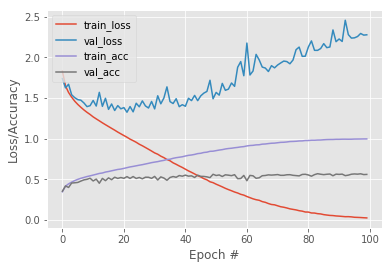

In [58]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import argparse

# construct the argument parse and parse the argument in commond line
ap = argparse.ArgumentParser()
ap.add_argument("-o","--output",
                required = True, help="path to the ouput loos/accuracy plot")
args = vars(ap.parse_args)

print("[INFO] loading CIFAR-10 data...")
(train_X,train_y),(test_X,test_y) = cifar10.load_data()
train_X = train_X.astype("float") / 255.0
test_X = test_X.astype("float") / 255.0

train_X = train_X.reshape((train_X.shape[0], 3072))#32*32*3 per image;5000 total
test_X = test_X.reshape((test_X.shape[0], 3072))

lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.fit_transform(test_y)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
              "dog", "frog", "horse", "ship", "truck"]

model = Sequential()
model.add(Dense(1024,input_shape=(3072,),activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(10,activation="softmax"))

# train the model with SGD
print("[INFO] training network...")
sgd = SGD(0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,
              metrics=["accuracy"])
H = model.fit(train_X, train_y, validation_data=(test_X,test_y),
              epochs = 100, batch_size=32)

# evaluate
print("[INFO] evaluating network...")
predictions = model.predict(test_X, batch_size=32)
print(classification_report(test_y.argmax(axis=1),predictions.argmax(axis=1),
      target_names=labelNames))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(args["output"])